# Predict Natual Gas Prices with SARIMA Model 

Seasonal autoregressive integrated moving average (SARIMA) model is used to forecast time series data for its convenience. 

## Part 1: Data Preparation

In the first part, I import the necessary libaries, import and convert the natual gas data, and plot the time series.

### 1-1: Import the libaries and define the parameters 

In [1]:
# basic libaries 
import pandas as pd
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# statistic models 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL

# Just personal preference of colours 
Kookaburra = "#003C55"
Possum = "#73234B"
DarkBlue = "061E3E"
Blue = "002960"
Red = "CD202C"
Turquoise = "006983"
Cyan = "0093D3"

### 1-2: Import the data

In [63]:
file_path = "Nat_Gas.csv"
gas = pd.read_csv(file_path)
gas["Dates"] = pd.to_datetime(gas["Dates"]) #convert Dates into date datatype
gas.set_index('Dates', inplace=True)
gas.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


Data description:
<li>Dates: YYYY-MM-DD</li>
<li>Prices: Natural gas price at the end of each month </li>

### 1-3: Plot the natual gas prices time series

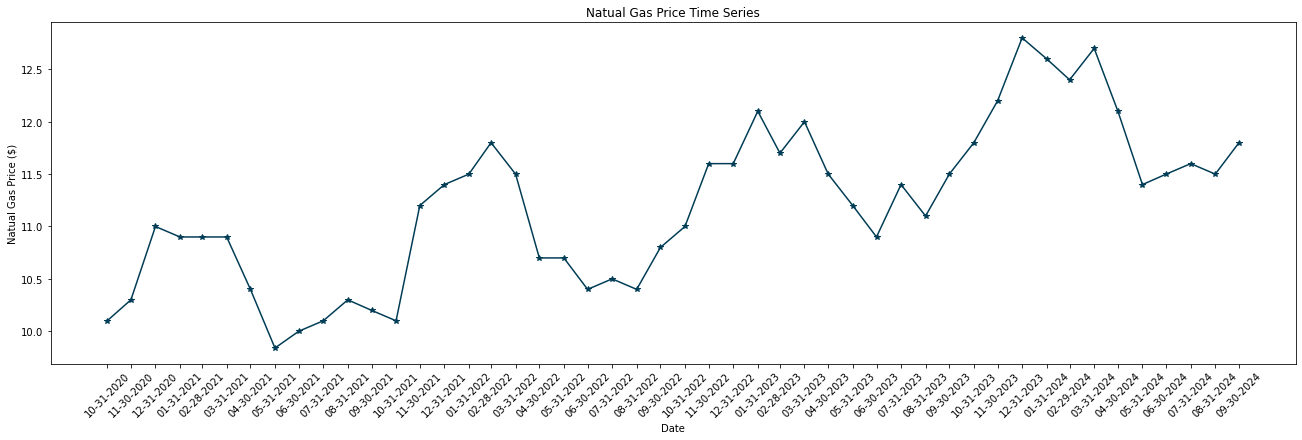

In [64]:
# visualise the time series 
plt.figure(figsize=(18, 6))  
plt.plot(gas, label='Natual Gas Price', color=Kookaburra, marker='*', linestyle='-')

# x-axis
plt.xlabel('Date')
plt.xticks(dates, rotation=45)

# format the date 
date_format = DateFormatter("%m-%d-%Y")  
plt.gca().xaxis.set_major_formatter(date_format) 

plt.tight_layout() # proper spacing

# y-axis
plt.ylabel('Natual Gas Price ($)')

# title
plt.title('Natual Gas Price Time Series')

plt.show()


The line chart exhibits seasonality in the natual gas price - the price increases at the end of October, reaching its pinnacle between November and Februry, before declining at the end of March. The line chart also shows an upward trend. 

## Part 2: Statistical Testing for Data

In part 2, I test if the data exhibits stationarity and seasonality with statisical methods, including Dickey-Fuller test, autocorrelaton and partial autocorrelation functions, and decomposition.

### 2-1: Stationarity with Dickey-Fuller Test

In [110]:
def ad_fuller(timeseries):
    print ('Dickey-Fuller Test indicates:')
    df_test = adfuller(timeseries, regression='ct', autolag='AIC')
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(output)

print(ad_fuller(gas["Prices"]))

Dickey-Fuller Test indicates:
Test Statistic                 -2.058395
p-value                         0.569301
#Lags Used                     10.000000
Number of Observations Used    37.000000
dtype: float64
None


The null hypothesis is failed to be rejected as the p-value is greater than 5%, suggesting that the data is not stationary.

### 2-2: Autocorrelation and Partial Autocorrelation Functions

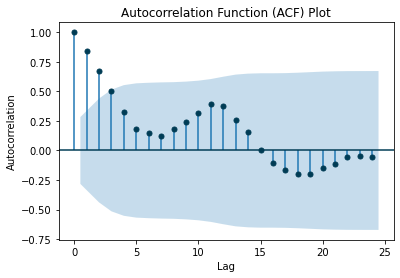

In [113]:
plot_acf(prices, lags=24, color = Kookaburra) 
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

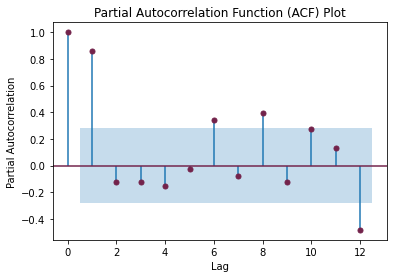

In [105]:
plot_pacf(prices, lags=12, color = Possum) 
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (ACF) Plot')
plt.show()

As the autocorrelation plot shows, the spikes at regular lag intervals examine seasonality.

###  2-3: Decompose the price into trends, seasonality, and residues

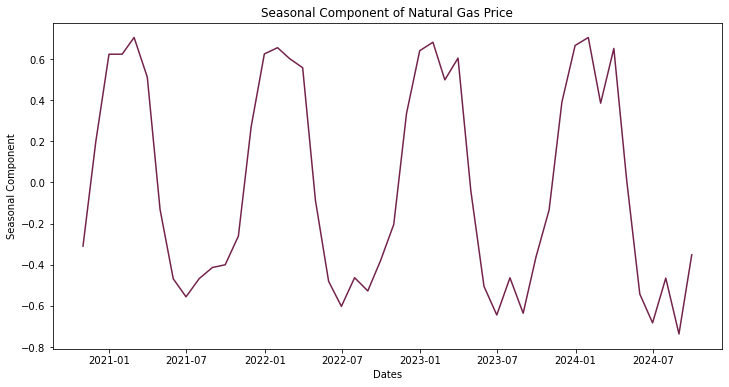

In [79]:
stl = STL(gas, seasonal = 13)  # Assuming monthly data with a yearly seasonality
result = stl.fit()
seasonal = result.seasonal

plt.figure(figsize=(12, 6))
plt.plot(gas.index, seasonal, color = Possum)
plt.xlabel('Dates')
plt.ylabel('Seasonal Component ($)')
plt.title('Seasonal Component of Natural Gas Price')
plt.show()

In [154]:
# store the seasonal factors by calculating the average seasonal factors of each month for the past four years
seasonality = np.mean(np.array(seasonal).reshape(12,4), axis = 1)

###  Trend factor

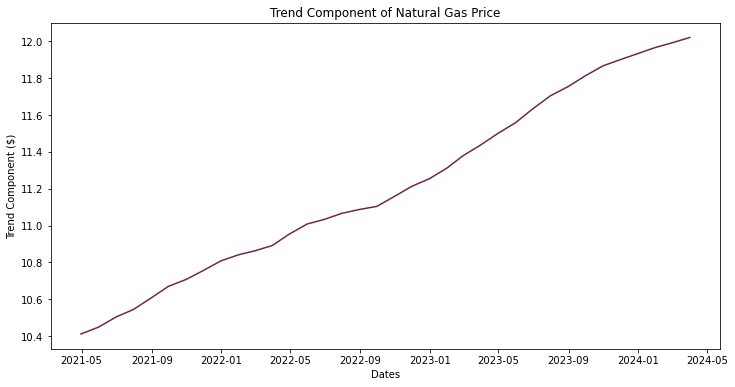

In [89]:
decomposition = sm.tsa.seasonal_decompose(gas['Prices'], model='additive')

plt.figure(figsize=(12, 6))
plt.plot(gas.index, decomposition.trend, color = Possum)
plt.xlabel('Dates')
plt.ylabel('Trend Component ($)')
plt.title('Trend Component of Natural Gas Price')
plt.show()

## Part3: Build and Test SARIMA Model

### 3-1: Split the data and set up a model 

In [202]:
test_size = 12 # use the last year for testing 

train_size = len(gas) - test_size

# Split the data into training and test sets
gas_train = gas.iloc[:train_size]
gas_test = gas.iloc[train_size:]

Based on the previous analysis, natural gas prices are non-stationary, so we can use d=1 and D=1 in case there is annual trend in some sort (just to be on the safe side).

### 3-2: Fit SARIMA model

In [257]:
p = 1
d = 1
q = 1
P = 0
D_seasonal = 1
Q = 1
seasonal_period = 12

model = sm.tsa.statespace.SARIMAX(gas_train, order = (p, d, q), 
                                  seasonal_order = (P, D_seasonal, Q, seasonal_period))
result = model.fit()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Prices   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  -2.432
Date:                            Tue, 21 Nov 2023   AIC                             12.864
Time:                                    13:03:54   BIC                             17.406
Sample:                                10-31-2020   HQIC                            14.006
                                     - 09-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2425      0.294     -0.825      0.410      -0.819       0.334
ma.L1         -0.9853      2.321   

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [258]:
# Forecast one year ahead
forecast_steps = 12
forecast = result.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean + seasonality 

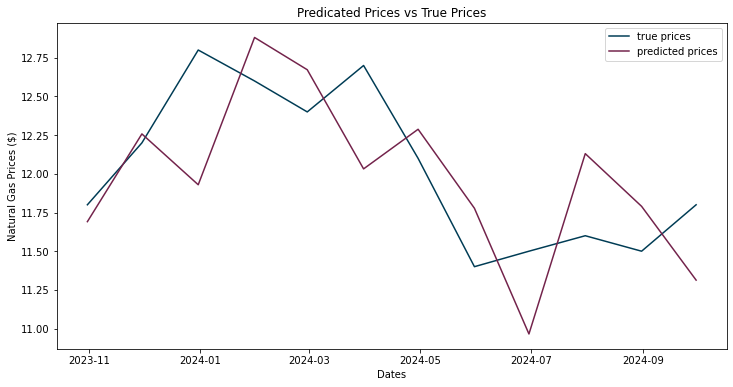

In [259]:
plt.figure(figsize=(12, 6))
plt.plot(gas_test, color = Kookaburra, label = "true prices")
plt.plot(forecast_values, color = Possum, label = "predicted prices")
plt.xlabel('Dates')
plt.legend()
plt.ylabel('Natural Gas Prices ($)')
plt.title('Predicated Prices vs True Prices')
plt.show()

### 3-3 Use the model to extrapolate the price for one year into the future. 

In [303]:
p = 1
d = 1
q = 1
P = 0
D_seasonal = 1
Q = 1
seasonal_period = 12

model = sm.tsa.statespace.SARIMAX(gas, order = (p, d, q), 
                                  seasonal_order = (P, D_seasonal, Q, seasonal_period))
result = model.fit()
forecast = result.get_forecast(steps = forecast_steps)
forecast_values = forecast.predicted_mean + seasonality 

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [304]:
forecast_values = forecast_values.to_frame(name = "Prices")
forecast_values.index = pd.to_datetime(forecast_values.index)
forecast_values.head()

,Prices
2024-10-31,12.307755
2024-11-30,12.747931
2024-12-31,12.510997
2025-01-31,13.366995
2025-02-28,13.117716


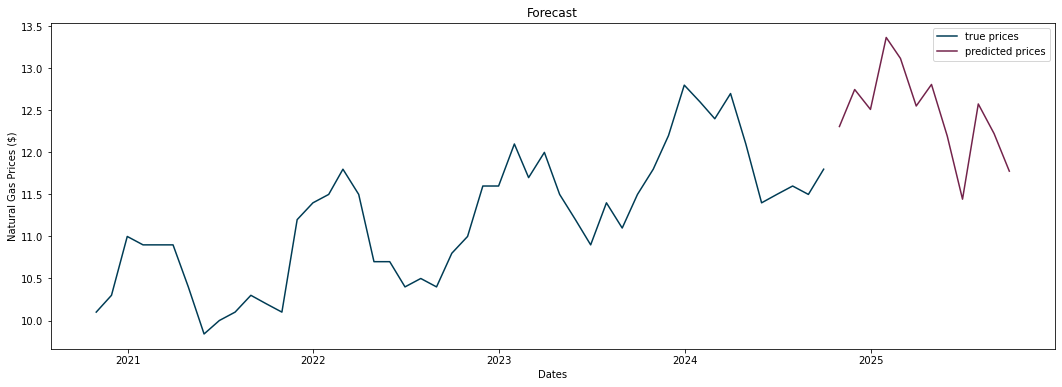

In [307]:
plt.figure(figsize=(18, 6))
plt.plot(gas, color = Kookaburra, label = "true prices")
plt.plot(forecast_values, color = Possum, label = "predicted prices")
plt.xlabel('Dates')
plt.legend()
plt.ylabel('Natural Gas Prices ($)')
plt.title('Forecast')
plt.show()

### 3-4 Save the forecasted prices

In [306]:
forecast_values.to_csv('forecast.csv', index=True)